<a href="https://colab.research.google.com/github/Pankaj-2003/Numerai_Models/blob/main/feature_neutralization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One thing that makes predicting the stock market so hard is the "non-stationary" relationship between features and returns. Features can have strong predictive power some eras but not others - or may completely reverse over time.

This uncertainty is what we call "feature risk". In order to create models that have consistent performance, it is helpful to reduce this feature risk via "feature neutralization"

In [1]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1

# Inline plots
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 24.7 MB/s eta 0:00:00


In [2]:
import json
import pandas as pd
from numerapi import NumerAPI

# initialize our API client
napi = NumerAPI()

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

In [3]:
napi.download_dataset(f"{DATA_VERSION}/features.json");
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]
sizes = ["small", "medium", "all"]
groups = [
  "intelligence",
  "wisdom",
  "charisma",
  "dexterity",
  "strength",
  "constitution",
  "agility",
  "serenity",
  "all"
]

v4.3/features.json: 1.12MB [00:00, 1.68MB/s]                           


In [4]:
subgroups = {}
for size in sizes:
  subgroups[size] = {}
  for group in groups:
    subgroups[size][group] = (
        set(feature_sets[size]).intersection(set(feature_sets[group]))
    )
pd.DataFrame(subgroups).applymap(len).sort_values(by = "all" , ascending = False)

,small,medium,all
all,42,705,2376
constitution,2,134,335
charisma,3,116,290
agility,2,58,145
wisdom,3,56,140
strength,1,54,135
serenity,3,34,95
dexterity,4,21,51
intelligence,2,14,35


In [5]:
# loading the "medium feature set"
medium_features = feature_sets["medium"]
# serenity feature of medium
med_serenity_feats = list(subgroups["medium"]["serenity"])

# load dataset
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet")

# loading only medium features
train = pd.read_parquet(f"{DATA_VERSION}/train_int8.parquet",columns = ["era" , "target"] + medium_features)

v4.3/train_int8.parquet: 2.09GB [03:30, 9.96MB/s]                            


In [6]:
# downsampling to every fourth era
train = train[train["era"].isin(train["era"].unique()[::4])]

In [7]:
# numerai tools
!pip install -q --no-deps numerai-tools
# import numerai_corr,source code here:
# https://github.com/numerai/numerai-tools/blob/master/numerai_tools/scoring.py
from numerai_tools.scoring import numerai_corr
import numpy as np


In [8]:
per_era_corr = train.groupby("era").apply(lambda d: numerai_corr(d[med_serenity_feats] , d["target"]))

In [9]:
per_era_corr *=np.sign(per_era_corr.mean())

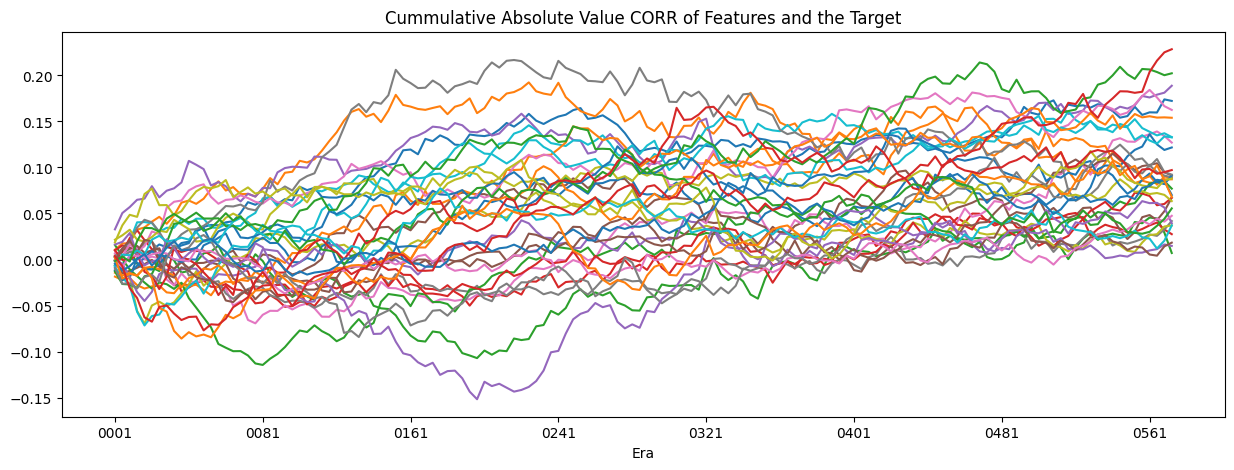

In [10]:
# plotting the per-era-correlations
per_era_corr.cumsum().plot(title = "Cummulative Absolute Value CORR of Features and the Target" , figsize = (15,5) , legend = False , xlabel = "Era");

In [11]:
def metric(corr):
  corr_mean = corr.mean()
  corr_std = corr.std(ddof = 0)
  corr_sharpe = corr_mean / corr_std
  max_drawdown = -(corr.cumsum().expanding(min_periods = 1).max() - corr.cumsum()).max()


# delta = absolute difference in mean correlation between the first and second half of analysis period.

  half = len(train["era"].unique())//2
  delta = abs(per_era_corr.iloc[:half].mean() - per_era_corr.iloc[half:].mean())


  df = pd.DataFrame({"mean": corr_mean,
    "std": corr_std.values,
    "sharpe": corr_sharpe.values,
    "max_drawdown": max_drawdown.values,
    "delta":delta.values},index = corr.columns).T

  return df.transpose().sort_values(by = "mean" , ascending = False)

In [12]:
metric(per_era_corr)

,mean,std,sharpe,max_drawdown,delta
feature_strigose_rugose_interjector,0.001587,0.009814,0.161706,-0.090501,3.219999e-04
feature_pennsylvanian_sibylic_chanoyu,0.001405,0.008630,0.162839,-0.056719,5.891572e-05
feature_honoured_observational_balaamite,0.001311,0.008323,0.157573,-0.070633,4.692690e-04
feature_ichthyotic_roofed_yeshiva,0.001197,0.006447,0.185643,-0.053682,8.730129e-04
feature_exploitative_jetty_oujda,0.001129,0.007438,0.151789,-0.048455,4.028365e-04
feature_styloid_subdermal_cytotoxin,0.001070,0.006940,0.154150,-0.058597,6.228628e-04
feature_plum_anemometrical_guessing,0.000924,0.006496,0.142234,-0.041113,1.081759e-03
feature_aguish_commissioned_tessitura,0.000922,0.008206,0.112337,-0.063597,1.338218e-03
feature_gubernacular_liguloid_frankie,0.000882,0.007530,0.117191,-0.082251,6.352135e-04
feature_demolished_unfrightened_superpower,0.000846,0.007418,0.113985,-0.053589,3.118252e-04


Looking at the summary visualizations below, the most obvious observation is that `mean` and `sharpe` seem strongly correlated. This should not be suprising given that `sharpe` is just `mean` divided by `std`.

A more interesting obvservation is that `mean` does not seem to be strongly correlated with `std`, `max_drawdown`, or `delta`. This tells us very clearly that just because a feature has high `mean` does not mean that it is consistent or low risk.

In the next section we more closely examine `std`, `max_drawdown`, and `delta` to better understand feature risk.

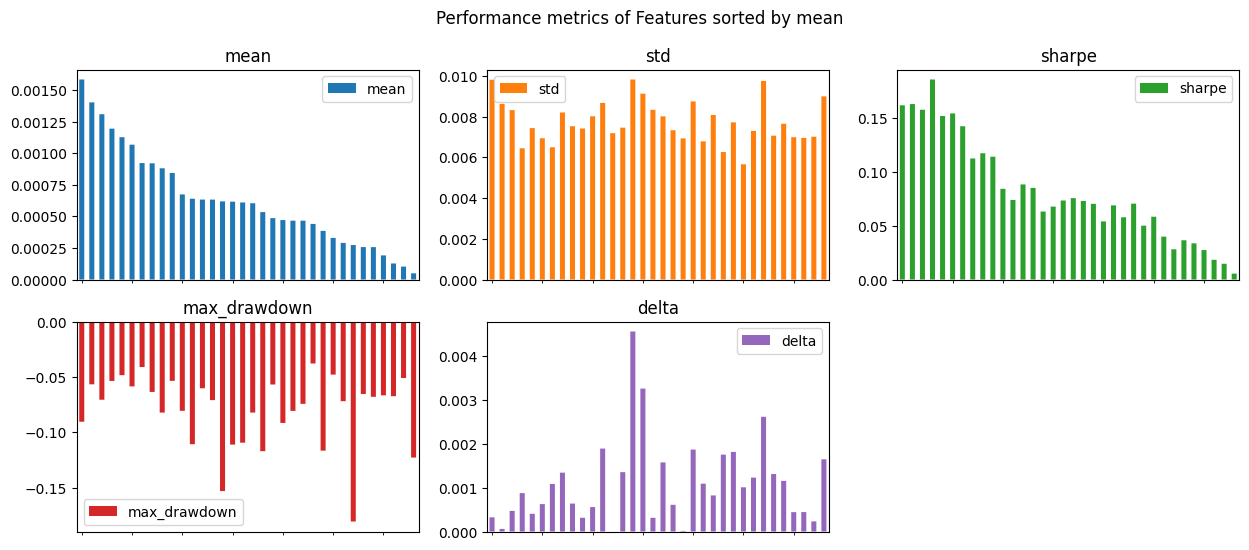

In [13]:
# examining std , delta, max_drawdown to understand feature risk better
metric(per_era_corr).plot(
    kind = 'bar' ,
    subplots = True,
    figsize = (15,6) ,
    layout = (2,3) ,
    title = "Performance metrics of Features sorted by mean" ,
    xticks = [] ,
    snap = False
);

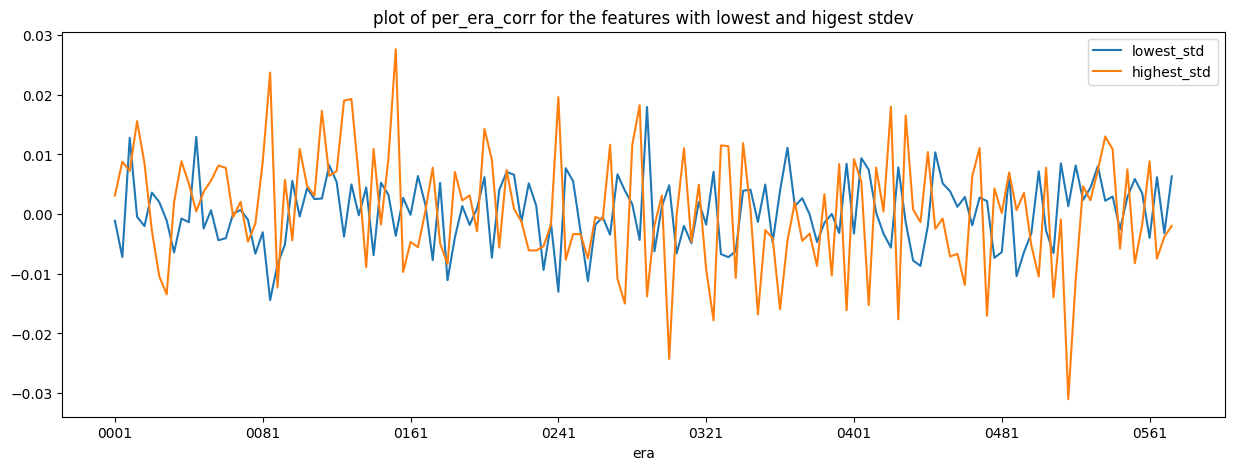

In [14]:
# comparing feature risk
import matplotlib.pyplot as plt

per_era_corr[[metric(per_era_corr)["std"].idxmin() , metric(per_era_corr)["std"].idxmax()]].plot(
    figsize = (15, 5) ,
    title = "plot of per_era_corr for the features with lowest and higest stdev"
  );
plt.legend(["lowest_std" , "highest_std"]);

# i think orange one is more risky

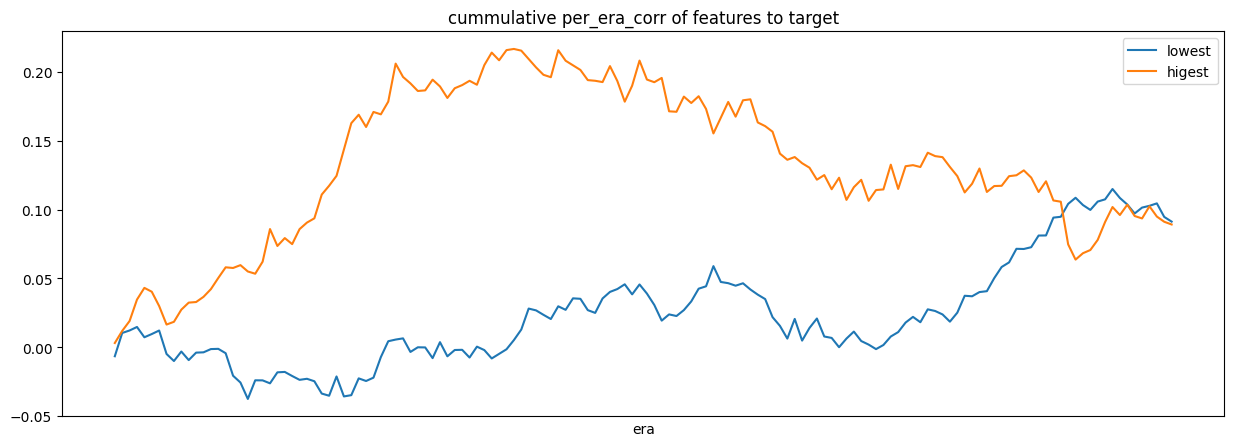

In [29]:
per_era_corr[[metric(per_era_corr)["delta"].idxmin(),metric(per_era_corr)["delta"].idxmax()]].cumsum().plot(xticks = [], title = "cummulative per_era_corr of features to target", figsize = (15,5));
plt.legend(["lowest" , "higest"]);

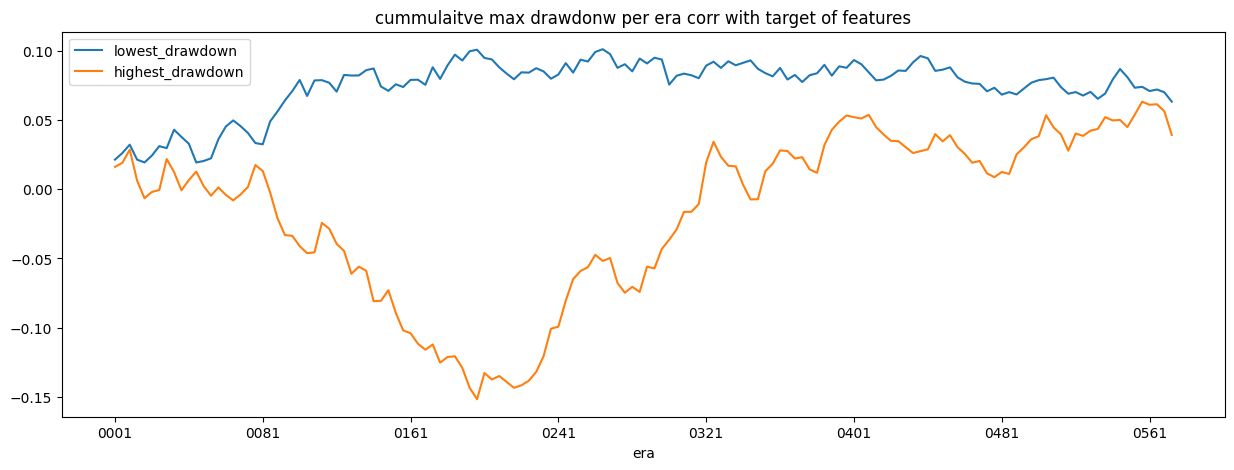

In [36]:
per_era_corr[[metric(per_era_corr)["max_drawdown"].idxmax() , metric(per_era_corr)["max_drawdown"].idxmin()]].cumsum().plot(title = "cummulaitve max drawdonw per era corr with target of features" , xlabel = "era" , figsize = (15,5));
plt.legend(["lowest_drawdown","highest_drawdown"]);

In [37]:
# model training
import lightgbm as lgb
model = lgb.LGBMRegressor(n_estimators = 2000 , learning_rate = 0.01 , max_depth = 5 , num_leaves = 2**4-1 , colsample_bytree = 0.1)
model.fit(train.drop("target" , axis = 1) , train["target"])


,feature_ichthyotic_roofed_yeshiva,feature_floriated_amish_sprite,feature_carolean_tearable_smoothie,feature_unadaptable_floored_styptic,feature_honoured_observational_balaamite,feature_nappiest_unportioned_readjustment,feature_gubernacular_liguloid_frankie,feature_reposeful_apatetic_trudeau,feature_olden_enchained_leek,feature_plum_anemometrical_guessing,...,feature_genuine_kyphotic_trehala,feature_diarrhoeic_relieved_scutter,feature_ironfisted_nonvintage_chlorpromazine,feature_iconoclastic_parietal_agonist,feature_blind_concordant_tribalist,feature_untidy_withdrawn_bargeman,feature_binding_lanky_rushing,feature_relinquished_incognizable_batholith,feature_divulsive_explanatory_ideologue,feature_synodal_thornier_zila
era,,,,,,,,,,,,,,,,,,,,,
0001,-0.001456,0.010645,0.015674,0.009941,0.032775,0.002767,-0.010124,-0.001070,-0.005702,0.002792,...,0.016323,-0.000904,-0.001120,-0.009258,0.018673,-0.006106,-0.004436,0.001698,-0.001749,0.003584
0005,-0.009250,0.006730,-0.011595,0.005337,0.017703,-0.017966,0.013729,0.003656,-0.000726,0.006992,...,0.002845,0.013039,-0.007193,-0.017075,0.018414,0.011473,-0.007686,-0.022476,0.005023,-0.010834
0009,-0.008840,0.000408,0.007482,-0.002377,0.006484,0.002976,0.005748,0.005640,-0.013228,0.009997,...,0.009575,0.008384,0.012780,0.000415,0.011493,-0.000830,0.004862,0.005266,-0.005420,-0.023819
0013,0.021060,0.014760,-0.016173,-0.003554,0.007946,0.003217,0.003535,-0.001781,-0.036276,0.020615,...,-0.022396,-0.012427,-0.000455,-0.005579,-0.002222,0.005216,0.007480,-0.001999,0.022135,-0.010784
0017,0.004878,0.002243,-0.005734,-0.008582,0.001204,0.003952,-0.012849,0.011669,-0.013902,0.000279,...,-0.012768,0.013036,-0.002018,0.012501,0.024805,-0.004406,0.005608,0.008810,0.014332,-0.021016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0557,-0.008793,-0.008771,-0.001333,0.002918,0.010123,0.015993,0.005528,0.002889,0.010108,-0.009674,...,0.009274,-0.001007,0.003489,0.001530,-0.002941,-0.007144,0.012044,-0.014597,-0.000897,0.009469
0561,0.002801,0.003450,0.006175,0.003951,-0.001667,0.002354,0.002670,0.004865,0.008131,-0.003977,...,-0.002203,-0.007605,-0.003990,-0.008786,-0.001321,-0.001459,0.002030,0.003418,0.002038,0.000599
0565,-0.000180,-0.009787,-0.000963,0.003087,0.003051,-0.005608,0.003039,-0.001530,0.000957,-0.003956,...,0.000359,-0.001277,0.006180,0.008122,-0.001541,-0.010725,0.006849,0.011999,0.006574,-0.005233


In [38]:
train

,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0.25,0,4,0,4,2,0,2,1,...,0,0,2,4,2,4,3,2,2,3
n003bee128c2fcfc,0001,0.75,4,2,2,2,2,3,2,1,...,3,3,2,0,2,2,1,3,2,1
n0048ac83aff7194,0001,0.25,4,4,2,0,2,0,2,4,...,0,1,2,0,2,3,2,1,2,2
n00691bec80d3e02,0001,0.75,1,4,1,1,2,0,2,2,...,2,1,2,2,2,3,2,2,2,2
n00b8720a2fdc4f2,0001,0.50,0,2,0,0,2,0,2,3,...,1,1,2,0,2,0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,0.25,4,2,4,4,3,1,0,0,...,4,1,2,1,3,2,2,2,1,1
nffc7d24176548a4,0573,0.50,0,3,3,4,2,0,2,3,...,2,0,2,4,2,0,2,1,2,3
nffc9844c1c7a6a9,0573,0.50,4,1,1,2,0,3,2,4,...,1,3,0,3,0,2,0,0,1,2
